In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import numpy as np
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/NewPortfolioManagment/data.csv')

data.head(11)

,date,coin,high,low,close
0,1643673600,ADA,2.722000e-05,2.722000e-05,2.722000e-05
1,1643673600,DOGE,3.680000e-06,3.680000e-06,3.680000e-06
2,1643673600,EOS,6.095000e-05,6.074000e-05,6.090000e-05
3,1643673600,FUND,7.000000e-07,7.000000e-07,7.000000e-07
4,1643673600,GLM,8.850000e-06,8.850000e-06,8.850000e-06
5,1643673600,SENSO,2.314000e-05,2.314000e-05,2.314000e-05
6,1643673600,STR,5.170000e-06,5.170000e-06,5.170000e-06
7,1643673600,XRP,1.605000e-05,1.602000e-05,1.603000e-05
8,1643673600,reversed_TUSD,2.608479e-05,2.599181e-05,2.600911e-05
9,1643673600,reversed_USDC,2.608090e-05,2.598102e-05,2.600308e-05


In [ ]:
# Select the relevant columns (low, high, close)
selected_columns = ['low', 'high', 'close']

# Reshape the data
num_features = len(selected_columns)
num_timestamps = 5
num_coins = len(data['coin'].unique())
num_samples = len(data) - num_timestamps + 1

reshaped_data = np.zeros((num_samples, num_features, num_timestamps, num_coins))
labels = np.zeros((num_samples, num_coins))

In [ ]:
for i in range(num_samples):
    for j, feature in enumerate(selected_columns):
        for k in range(num_timestamps):
            start_index = i + k
            end_index = start_index + num_coins
            reshaped_data[i, j, k, :] = data[feature].iloc[start_index:end_index].values

    next_date_start_index = i + num_timestamps
    next_date_end_index = next_date_start_index + num_coins
    labels[i, :] = data['close'].iloc[next_date_start_index:next_date_end_index].values

reshaped_data = torch.from_numpy(reshaped_data).float()
labels = torch.from_numpy(labels).float()

print("Input data shape:", reshaped_data.shape)
print("Labels shape:", labels.shape)

ValueError: ignored

**For Testing:**
Shorten the dataset (divided by 10)

In [ ]:
# Select the relevant columns (low, high, close)
selected_columns = ['low', 'high', 'close']

# Reshape the data
num_features = len(selected_columns)
num_timestamps = 5
num_coins = len(data['coin'].unique())
num_samples = len(data) // (num_timestamps * num_coins)

reshaped_data = np.zeros((num_samples, num_features, num_timestamps, num_coins))
labels = np.zeros((num_samples, num_coins))


In [ ]:
for i in range(num_samples):
    for j, feature in enumerate(selected_columns):
        for k in range(num_timestamps):
            start_index = i * (num_timestamps * num_coins) + k * num_coins
            end_index = start_index + num_coins
            reshaped_data[i, j, k, :] = data[feature].iloc[start_index:end_index].values

    next_date_start_index = (i + 1) * (num_timestamps * num_coins)
    next_date_end_index = next_date_start_index + num_coins
    labels[i, :] = data['close'].iloc[next_date_start_index:next_date_end_index].values

reshaped_data = torch.from_numpy(reshaped_data).float()
labels = torch.from_numpy(labels).float()

print("Input data shape:", reshaped_data.shape)
print("Labels shape:", labels.shape)


Input data shape: torch.Size([4896, 3, 5, 11])
Labels shape: torch.Size([4896, 11])


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(
    reshaped_data, labels, test_size=0.2, random_state=42)

# train_data, val_data, train_labels, val_labels = train_test_split(
#     train_val_data, train_val_labels, test_size=0.1, random_state=42)

print("Train data shape:", train_data.shape)
# print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)
print("Train labels shape:", train_labels.shape)
# print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)


Train data shape: torch.Size([3916, 3, 5, 11])
Test data shape: torch.Size([980, 3, 5, 11])
Train labels shape: torch.Size([3916, 11])
Test labels shape: torch.Size([980, 11])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CryptocurrencyModel(nn.Module):
    def __init__(self, input_channels):
        super(CryptocurrencyModel, self).__init__()

        self._last_portfolio_price = torch.tensor(1.0)

        # 1*3 convolution with output of 2 feature maps
        self.conv1 = nn.Conv2d(input_channels, 2, kernel_size=(3, 1))

        # 1*8 convolution with output of 20 feature maps
        self.conv2 = nn.Conv2d(2, 20, kernel_size=(3, 1))

        self.initial_last_w = torch.zeros(12, 1)
        self.initial_last_w.data[0] = 1.0
        self.last_w = nn.Parameter(self.initial_last_w.clone())

        # 1*1 convolution with output of 1 feature map
        self.conv3 = nn.Conv2d(21, 1, kernel_size=(1, 1))

        self.relu = nn.ReLU()

        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):

        first_layer = self.relu(self.conv1(x))

        second_layer = self.relu(self.conv2(first_layer))

        last_w_wfe = self.last_w[1:].clone()

        third_layer_input = torch.cat([last_w_wfe.view(1, 1, 11), second_layer], dim=0)

        third_layer = self.conv3(third_layer_input)

        cash_bias = self.last_w[0].clone()
        forth_layer_input = torch.cat([cash_bias, third_layer.view(11)], dim=0)

        output = self.softmax(forth_layer_input.view(12))

        self.last_w.data = output.view(12, 1).clone()

        return output


    @property
    def last_portfolio_price(self):
        return self._last_portfolio_price

    @last_portfolio_price.setter
    def last_portfolio_price(self, value):
        # You can add validation logic here if needed
        self._last_portfolio_price = value


In [ ]:
class Metrics:
    def __init__(self):
        self._last_w = torch.zeros(12)
        # print(self._last_w.shape)
        self._last_w.data[0] = 1.0

        self._last_value = torch.tensor([1.0], requires_grad = True)
        self._last_label = torch.tensor([[2.722e-05, 3.68e-06, 6.074e-05, 7e-07, 8.85e-06, 2.314e-05, 5.17e-06, 1.604e-05, 2.599180842165783e-05, 2.5981017229571388e-05, 2.59986132339701e-05]],requires_grad = True)

    @property
    def last_w(self):
        return self._last_w

    @last_w.setter
    def last_w(self, vector):
        self._last_w = vector

    @property
    def last_value(self):
        return self._last_value

    @last_value.setter
    def last_value(self, scaler):
        self._last_value = scaler

    @property
    def last_label(self):
        return self._last_label

    @last_label.setter
    def last_label(self, vector):
        self._last_label = vector


In [ ]:
import torch.optim as optim
import copy

# Initialize the last portfolio price with 1 for the first time
metric = Metrics()


def custom_loss(output, label):

    last_label = metric.last_label
    y = label / last_label
    y = torch.cat((torch.tensor([1]).view(1, 1), y), dim=1)

    last_value = metric.last_value

    last_w = metric.last_w.view(12, 1)

    w_diff = output - last_w
    w_diff_abs = torch.abs(w_diff)

    coumition_rate = w_diff_abs.sum() * 0.3



    # portfolio_value = torch.tensor(last_value * torch.mm(y, last_w))

    # Create the reward tensor with requires_grad set to True
    # reward = -torch.mm(y, last_w)
    # reward.requires_grad = True
    reward = torch.mm(y, last_w)
    reward = reward * (1 - coumition_rate)
    reward = reward.requires_grad_()

    tmp_w = output.detach()
    metric.last_w = copy.deepcopy(tmp_w)

    tmp_label = label.detach()
    metric.last_label = copy.deepcopy(tmp_label)

    # tmp_value = portfolio_value.detach()
    # metric.last_value = copy.deepcopy(tmp_value)

    return -reward


    # print(last_wb.shape)
    # print(label.shape)

    # print("--------")

    # print(torch.tensor([last_cash]).view(1, 1).shape)
    # print((last_wb * label).shape)

    # print(torch.tensor([output_cash]).view(1, 1).shape)
    # print((output_wb * label).shape)


    # output_wb = output[1:]
    # # print(output.shape)
    # output_cash = output[0]

    # last_portfolio_vector = torch.cat((torch.tensor([last_cash]).view(1, 1), last_wb * label), dim=1)

    # portfolio_vector = torch.cat((torch.tensor([output_cash]).view(1, 1), output_wb * label), dim=1)

    # print('last Value', last_portfolio_vector.sum(), 'new Value', portfolio_vector.sum())

    # loss = -torch.log(portfolio_vector.sum()/last_portfolio_vector.sum())

    # global first_time
    # if first_time is None:
    #   print(portfolio_vector.sum())
    #   first_time = 1

    return reward



In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

custom_dataset = CustomDataset(train_data, train_labels)

batch_size = 1
train_loader = DataLoader(custom_dataset, batch_size=batch_size)



##Just for Testing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Create a DataLoader for your data
batch_size = 1  # You can adjust the batch size

train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = CryptocurrencyModel(input_channels=3)

# Define a loss function (criterion) and an optimizer
criterion = nn.MSELoss()  # You can choose an appropriate loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate

# Training loop
num_epochs = 10  # You can adjust the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs.view(3, 10, 11))
        loss = criterion(outputs[1:], labels.view(1, 11), model)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")

# Save the trained model if needed
# torch.save(model.state_dict(), 'cryptocurrency_model.pth')


RuntimeError: ignored

In [ ]:
model = CryptocurrencyModel(input_channels=3)

learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Saving data for Plotting
loss_values = []
portfolio_values = []

num_epochs = 200
for epoch in range(num_epochs):

  for inputs, labels in train_loader:

    loss_values.append([])

    inputs = inputs.view(3, 5, 11)
    labels = labels.view(1, 11)

    optimizer.zero_grad()

    outputs = model(inputs)

    # is_last_iteration = i == len(train_loader) - 1

    loss = custom_loss(outputs, labels)

    loss.backward()

    optimizer.step()

    loss_values[epoch].append(-loss.item())

  metric.last_value = metric.last_value * sum(loss_values[epoch])/len(loss_values[epoch])
  portfolio_values.append(metric.last_value.item())

  if epoch % 10 == 0:
    print(f'Epoch [{epoch}/{num_epochs}], Lose: {sum(loss_values[epoch])/len(loss_values[epoch])}')
    print(f'Portfolio Value: {metric.last_value.item()}')

# print('last portfolio value:', copy.deepcopy(metric.last_w))

Epoch [0/200], Lose: 0.996725966250172
Portfolio Value: 0.9967259764671326
Epoch [10/200], Lose: 1.0006026030043416
Portfolio Value: 0.9973880648612976
Epoch [20/200], Lose: 1.0009815793511085
Portfolio Value: 1.0058053731918335


KeyboardInterrupt: ignored

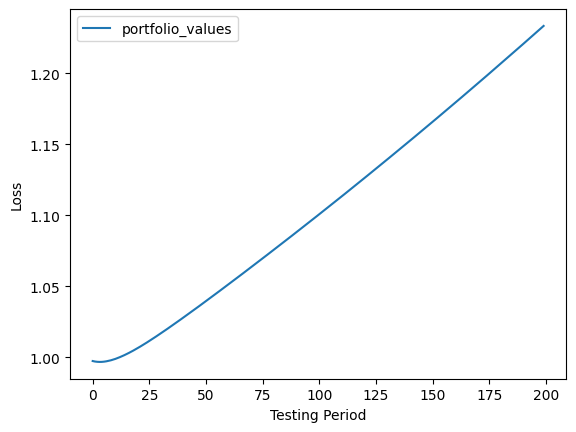

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), portfolio_values, label='portfolio_values')
plt.xlabel('Testing Period')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_dataset = CustomDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

metric = Metrics()

test_loss_values = []

model.eval()

with torch.no_grad():

    for inputs, labels in test_loader:
        inputs = inputs.view(3, 5, 11)
        labels = labels.view(1, 11)

        outputs = model(inputs)

        loss = custom_loss(outputs, labels)

        test_loss_values.append(-loss.item())


      metric.last_value = metric.last_value * sum(test_loss_values) / len(test_loss_values)
      test_portfolio_values.append(metric.last_value.item())